In [1]:
# from pycaret.time_series import *
# from supervised.automl import AutoML

import pandas as pd
import numpy as np
# import category_encoders as ce
import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
%matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor 
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
# import platform
import itertools
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

# with rawdata

In [25]:
news_df2 = pd.read_csv('../../data/scraping/stocknewsapi_rawdata.csv',index_col=0)
print(news_df2.shape)
news_df2.head(1)

(3420, 10)


,news_url,title,text,source_name,date,topics,sentiment,type,news_id,rank_score
0,https://www.youtube.com/watch?v=PAwREs7snJk,How Netflix is everything to everyone,Netflix is sitting on the streaming throne bec...,CNN,2018-06-28 20:00:00-04:00,[],Neutral,Video,1190,5.61


In [26]:
news_df2['date'] = news_df2['date'].apply(lambda x : 
                   pd.to_datetime(str(x)[:11]))
print(news_df2.shape)
news_df2.info()

(3420, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 3420 entries, 0 to 2
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   news_url     3420 non-null   object        
 1   title        3420 non-null   object        
 2   text         3420 non-null   object        
 3   source_name  3420 non-null   object        
 4   date         3420 non-null   datetime64[ns]
 5   topics       3420 non-null   object        
 6   sentiment    3420 non-null   object        
 7   type         3420 non-null   object        
 8   news_id      3420 non-null   int64         
 9   rank_score   3420 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 293.9+ KB


In [27]:
news_df_sorted2 = news_df2.sort_values('date')
news_df_sorted2 = news_df_sorted2.set_index('news_id')

In [28]:
# drop duplicates
news_df_dd2 = news_df_sorted2.drop_duplicates()
news_df_dd2.shape

(3410, 9)

In [29]:
'''
source_name > labelencoding
topics > labelencoding
    if None > 'Undefined'
    if multiple > then first topic
sentiment > onehot encoding
type > onehot encoding
rank_score
'''
nd2 = news_df_dd2[['source_name',
                  'topics','sentiment','type','rank_score','date']]
nd_2 = nd2.copy()

### source_name
le2 = LabelEncoder()
nd2['source_name'] = le2.fit_transform(nd2['source_name'])

### topics
import ast
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return [] # if error occurs return empty list
def extract_topic(topic_list):
    if len(topic_list)==0:
        return 'Undefined'
    return topic_list[0]
nd2['topics'] = nd2['topics'].apply(string_to_list)
nd2['topics'] = nd2['topics'].apply(extract_topic)
nd2['topics'] = le2.fit_transform(nd2['topics'])

### sentiment & type
onehot_cols = ['sentiment','type']
oe2 = OneHotEncoder()
encoded2 = oe2.fit_transform(nd2[onehot_cols])
feature_names2 = oe2.get_feature_names_out(onehot_cols)
encoded_dense2 = encoded2.toarray()
#combine
nd2.drop(columns=['sentiment','type'],inplace=True)
encoded_df2 = pd.DataFrame(encoded_dense2,
                           columns=feature_names2,
                           index=nd2.index)
nd2 = pd.concat([nd2,encoded_df2],axis=1)

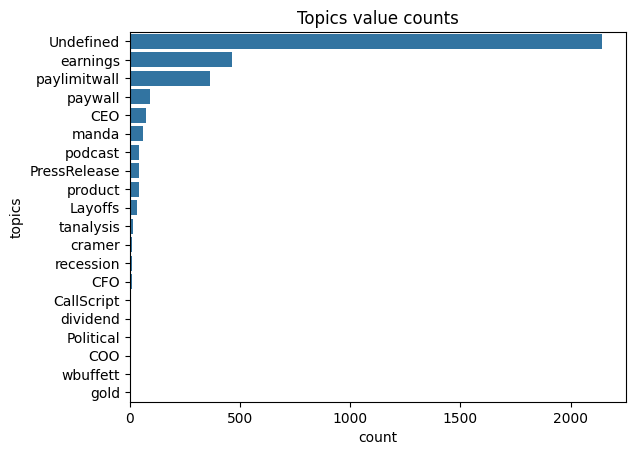

In [30]:
### Check for topics distribution
import ast
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return [] # if error occurs return empty list
def extract_topic(topic_list):
    if len(topic_list)==0:
        return 'Undefined'
    return topic_list[0]

temp2 = nd_2['topics'].apply(string_to_list)
topic_col2 = temp2.apply(extract_topic)
topic_col2.unique()
sns.barplot(topic_col2.value_counts(),orient='h')
plt.title('Topics value counts')
# plt.savefig('../../plots/topic_value_counts_for_news.png',dpi=300)
plt.show()

In [31]:
### processed nd dataframe
print(nd2.info())
nd2.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 3410 entries, 353 to 2211934
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   source_name         3410 non-null   int32         
 1   topics              3410 non-null   int32         
 2   rank_score          3410 non-null   float64       
 3   date                3410 non-null   datetime64[ns]
 4   sentiment_Negative  3410 non-null   float64       
 5   sentiment_Neutral   3410 non-null   float64       
 6   sentiment_Positive  3410 non-null   float64       
 7   type_Article        3410 non-null   float64       
 8   type_Video          3410 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int32(2)
memory usage: 239.8 KB
None


,source_name,topics,rank_score,date,sentiment_Negative,sentiment_Neutral,sentiment_Positive,type_Article,type_Video
news_id,,,,,,,,,
353,7,7,6.56,2018-02-13,0.0,1.0,0.0,0.0,1.0
145,7,7,6.56,2018-03-29,0.0,1.0,0.0,0.0,1.0
415,20,7,6.49,2018-04-15,0.0,1.0,0.0,0.0,1.0
411,4,7,5.24,2018-04-15,0.0,1.0,0.0,0.0,1.0
417,4,7,5.24,2018-04-16,0.0,1.0,0.0,0.0,1.0
1085,20,7,6.49,2018-06-12,0.0,1.0,0.0,0.0,1.0
1190,11,7,5.61,2018-06-28,0.0,1.0,0.0,0.0,1.0
1283,9,7,6.54,2018-07-11,0.0,1.0,0.0,0.0,1.0
1300,20,7,6.49,2018-07-12,0.0,1.0,0.0,0.0,1.0


In [32]:
### 중복된 날짜의 경우 rank_score가 가장 높은 행만 남김
nd_sort2 = nd2.sort_values(by=['date','rank_score'],ascending=[True,False])
nd_filtered2 = nd_sort2.drop_duplicates(subset='date',keep='first')
print(nd_filtered2.shape)
nd_filtered2.head(10)

(939, 9)


,source_name,topics,rank_score,date,sentiment_Negative,sentiment_Neutral,sentiment_Positive,type_Article,type_Video
news_id,,,,,,,,,
353,7,7,6.56,2018-02-13,0.0,1.0,0.0,0.0,1.0
145,7,7,6.56,2018-03-29,0.0,1.0,0.0,0.0,1.0
415,20,7,6.49,2018-04-15,0.0,1.0,0.0,0.0,1.0
417,4,7,5.24,2018-04-16,0.0,1.0,0.0,0.0,1.0
1085,20,7,6.49,2018-06-12,0.0,1.0,0.0,0.0,1.0
1190,11,7,5.61,2018-06-28,0.0,1.0,0.0,0.0,1.0
1283,9,7,6.54,2018-07-11,0.0,1.0,0.0,0.0,1.0
1322,9,7,6.54,2018-07-12,0.0,1.0,0.0,0.0,1.0
1342,9,7,6.54,2018-07-15,0.0,1.0,0.0,0.0,1.0


In [34]:
nd_filtered.to_csv('../../data/scraping/news_processed_filtered.csv')

In [35]:
nd_filtered = pd.read_csv('../../data/scraping/news_processed_filtered.csv')
nd_filtered.head(3)

,news_id,source_name,topics,rank_score,date,sentiment_Negative,sentiment_Neutral,sentiment_Positive,type_Article,type_Video
0,353,7,7,6.56,2018-02-13,0.0,1.0,0.0,0.0,1.0
1,145,7,7,6.56,2018-03-29,0.0,1.0,0.0,0.0,1.0
2,415,20,7,6.49,2018-04-15,0.0,1.0,0.0,0.0,1.0
